In [136]:
import pandas as pd
import numpy as np
## 대여기록
seoul_bike = pd.read_parquet("/Users/yangwoolee/git_repo/seoulBikeProject/parquet/220607_bike_record.parquet.gzip")
## 따릉이 대여소 정보
btstation = pd.read_csv(
    "assets/bkstation_info(backup).csv", encoding="CP949", index_col=0
)

### 특정 따릉이 대여소 대여기록만 추출

In [137]:

def raw_data( st_id: int) -> pd.DataFrame:
    quert_st_id1 = seoul_bike[seoul_bike["st_id1"] == st_id]
    quert_st_id2 = seoul_bike[seoul_bike["st_id2"] == st_id]
    filtered_data = pd.concat(
        [quert_st_id1, quert_st_id2], axis=0
    ).drop_duplicates()
    filtered_data.drop(columns="index", inplace=True)
    bm = (filtered_data["st_id1"] == st_id) & (filtered_data["st_id2"] == st_id)
    filtered_data = filtered_data[~bm]

    return filtered_data

raw_data(207)

,date,st_id1,st_id2,riding_time,dist
148664,2021-07-01 00:12:32,207,276,18,4515.82
148665,2021-07-01 00:16:05,207,287,20,3645.38
148667,2021-07-01 00:15:17,207,1831,37,9230.96
148668,2021-07-01 00:31:12,207,1906,21,4952.75
148669,2021-07-01 00:33:16,207,1906,20,4419.12
...,...,...,...,...,...
26997034,2021-06-30 22:12:43,2308,207,115,12764.29
26998072,2021-06-30 22:35:50,2196,207,143,21064.85
26998073,2021-06-30 22:34:18,2196,207,145,21491.70
26998074,2021-06-30 22:34:18,2196,207,145,24130.00


### 특정 대여소에서 출발한 자전거의 도착 대여소 정보를 종합

In [138]:

def arrStation(st_id: int) -> pd.DataFrame:
    filtered_data = raw_data(st_id)
    all_record  = filtered_data.groupby(by="st_id2").size()

    # 대여기록 50건 이상 총 200개 대여소만 추출하기
    # sort_info = all_record[all_record > 50].sort_values(ascending=False)[1:201]
    sort_info = all_record[all_record > 50].sort_values(ascending=False)
    station_id = sort_info.index.to_list()

    result = btstation.query("value == @station_id").reset_index(drop=True)

    result_station = []
    for j in result['value']:
        # 예상시간 계산
        BM = filtered_data["st_id2"] == j
        all_rent = (
            filtered_data[BM]["riding_time"]
            .value_counts()
            .sort_values(ascending=False)
        )

        ### 대여기록
        total_record = all_rent.sum()

        k = []
        i = 2
        ### 기록 많은 순만 종합
        while len(k) < 1:
            k = all_rent[all_rent >= (total_record / i)]
            i = i * 1.5

        ### 대여시간
        ind = k.index
        ### 대여기록
        val = k.values
        ### 대여기록 합
        a = k.sum()
        ### 대여시간 * 대여기록
        asddd = sum([a * b for a, b in zip(ind, val)])
        # 평균 시간
        ddddd = asddd / a

        # 올림
        val = round(ddddd, 0)

        ### 이동거리 계산
        BM = filtered_data["st_id2"] == j
        all_rent = (
            filtered_data[BM]["dist"].value_counts().sort_values(ascending=False)
        )

        dist = (
            pd.cut(all_rent.index, bins=50)
            .value_counts()
            .sort_values(ascending=False)
        )
        # 상위 3개 값을 평균냄. mid는 pd.interval 매서드에서 쓰는 변수임.
        num = 3
        vals = [dist[:num].index[a].mid * dist.iloc[a] for a in range(num)]
        avg_dist = sum(vals) / sum(dist.to_list()[:num])

        result_station.append([val, total_record, (round(avg_dist / 1000, 2))])

    df = pd.DataFrame(result_station)
    data = pd.concat([result, df], axis=1)
    data.columns = ["value", "label", "coor", "num", "time", "record", "dist"]
    data=data[data['value'] !=st_id]

    return data

arrStation(207)

,value,label,coor,num,time,record,dist
0,102,망원역 1번출구 앞,"[37.555649, 126.910629]",62074,61.0,52,6.74
1,103,망원역 2번출구 앞,"[37.554951, 126.910835]",51577,46.0,85,6.90
2,105,합정역 5번출구 앞,"[37.550007, 126.914825]",20609,51.0,69,5.89
3,106,합정역 7번출구 앞,"[37.548645, 126.912827]",63341,38.0,714,5.70
4,108,서교동 사거리,"[37.552746, 126.918617]",30309,51.0,83,6.20
...,...,...,...,...,...,...,...
290,4616,신용산지하차도 앞,"[37.53248215, 126.964119]",7755,20.0,67,3.97
291,4619,한강트럼프월드3차 앞,"[37.52301788, 126.96241]",17695,36.0,68,4.43
292,152,마포구민체육센터 앞,"[37.55661, 126.898018]",104386,44.0,261,7.22
293,218,증권거래소 앞,"[37.523277, 126.929237]",8566,4.0,487,0.46


### 따릉이 대여소 대여기록 top 30 추출

In [139]:
k = btstation.sort_values(ascending=False,by='num')
a = k[:30]
b = a['value'].tolist()
asd = list(map(arrStation,b))
asdddd = pd.concat(asd)

## 분석 결과

Top 30 대여소의 대여기록을 바탕으로 작성

### Scatter Plot

### 0~3km는 음의 상관 관계를 확인할 수 있음

<AxesSubplot:xlabel='distance', ylabel='counts'>

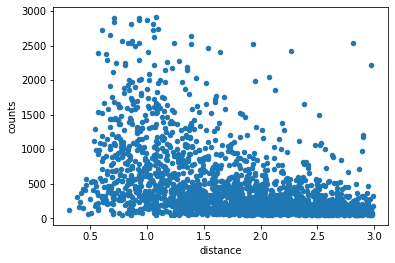

In [185]:
asdddd[['record','dist']].query('dist < 3 & record < 3000').plot.scatter(y='record',x='dist',xlabel='distance',ylabel='counts')

### 3~20km는 거리와 기록의 상관관계를 확인할 수 없음

<AxesSubplot:xlabel='distance', ylabel='counts'>

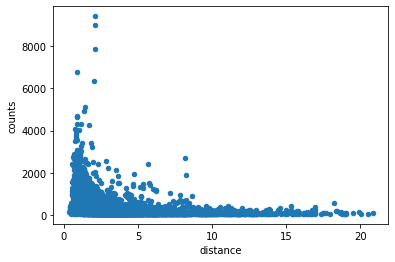

In [184]:
asdddd[['record','dist']].plot.scatter(y='record',x='dist',xlabel='distance',ylabel='counts')

### Barplot

### Barplot에서도 0~3km에서는 상관관계를 보이지만 이후 거리에는 상관관계를 확인할 수 없음.

<AxesSubplot:xlabel='distance', ylabel='avgCounts'>

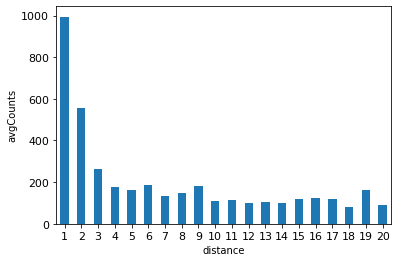

In [186]:
bbb = asdddd[['record','dist']]
label = list(range(1,21))
asd = pd.cut(asdddd['dist'],bins=range(0,21),labels=label,precision=3)
asdddd['cut'] = asd
cc = asdddd.groupby(by='cut').mean()['record']
cc.plot.bar(xlabel='distance',ylabel='avgCounts',fontsize=11,rot=0)